In [23]:
# imports
from __future__ import annotations
import gym
import torch
import torch.nn
import torch.nn.functional
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm.notebook import tqdm
from dataclasses import dataclass
from itertools import count
import math

In [24]:
# config
%matplotlib ipympl

TRAIN_EPISODES = 50 #@param {type:"integer"}
BATCH_SIZE = 128 #@param {type:"integer"}
MEMORY_SIZE = 10000 #@param {type:"integer"}

LEARNING_RATE = 0.001 #@param {type:"number"}
LEARNING_RATE_GAMMA = 0.9 #@param {type:"number"}
LEARNING_RATE_UPDATE_INTERVAL = 1000 #@param {type:"integer"}

REWARD_GAMMA = 0.99   #@param {type:"number"}

EPSILON_START = 0.9
EPSILON_END = 0.05
EPSILON_DECAY = 200

PREVIEW_EPISODE_INTERVAL = 1 #@param {type:"integer"}

POLICY_TARGET_UPDATE_INTERVAL = 10 #@param {type:"integer"}
SOFT_UPDATE_TAU = 0.001  #@param {type:"number"}

In [25]:
# typedefs
State = torch.Tensor
Action = int
Reward = float
StateBatch = torch.Tensor
ActionBatch = torch.Tensor
RewardBatch = torch.Tensor
TerminalBatch = torch.Tensor

In [26]:
class DQN(torch.nn.Module):
    def __init__(self, num_actions: int):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,16)
        self.bn1 = torch.nn.BatchNorm1d(16)
        self.fc2 = torch.nn.Linear(16,32)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.fc3 = torch.nn.Linear(32,32)
        self.bn3 = torch.nn.BatchNorm1d(32)
        self.out = torch.nn.Linear(32, num_actions)

    def forward(self, x: StateBatch) -> ActionBatch:
        x = torch.nn.functional.relu(self.bn1(self.fc1(x)))
        x = torch.nn.functional.relu(self.bn2(self.fc2(x)))
        x = torch.nn.functional.relu(self.bn3(self.fc3(x)))
        x = self.out(x)
        return x

In [27]:
# weight update functions
# from https://github.com/ghliu/pytorch-ddpg/blob/master/util.py#L26
def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            ## shouldn't be necessary since we use target networks to calculate loss
            # if isinstance(target_param, torch.nn.parameter.UninitializedParameter):
            #     # target model uninitialize, hard update
            #     target_param.data.copy_(param.data)
            # else:
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [28]:
# transitions
@dataclass
class Transition:
    state: State
    action: Action
    reward: Reward
    next_state: State
    terminal: bool

@dataclass
class TransitionBatch:
    states: StateBatch
    actions: ActionBatch
    rewards: RewardBatch
    next_states: StateBatch
    terminals: TerminalBatch

In [29]:
# env = gym.make("MountainCar-v0")
env = gym.make("CartPole-v0")

In [30]:
print(env.observation_space)
print(env.reset())


Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
[-0.02354074  0.02588752  0.0446174  -0.01471785]


In [31]:
print(env.action_space)
print(env.action_space.n)

Discrete(2)
2


In [32]:
memory = deque(maxlen=MEMORY_SIZE)

In [33]:
def sample_memory(batch_size: int) -> TransitionBatch:
    samples = random.sample(memory, batch_size)
    return TransitionBatch(
        states=torch.stack([s.state for s in samples]),
        actions=torch.as_tensor([s.action for s in samples], dtype=torch.int64),
        rewards=torch.as_tensor([s.reward for s in samples], dtype=torch.float32),
        next_states=torch.stack([s.next_state for s in samples]),
        terminals=torch.as_tensor([s.terminal for s in samples], dtype=torch.bool),
    )

In [34]:
# instantiate models
policy = DQN(env.action_space.n)
policy_target = DQN(env.action_space.n)
policy_target.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [35]:
def get_action(state: State) -> Action:
    global epsilon
    if random.random() < epsilon:
        return env.action_space.sample()
    state_batch = state.unsqueeze(0)
    policy.eval()
    with torch.no_grad():
        q_values = policy(state_batch)
    return int(q_values.argmax(dim=1).squeeze()) # return action with highest q-value

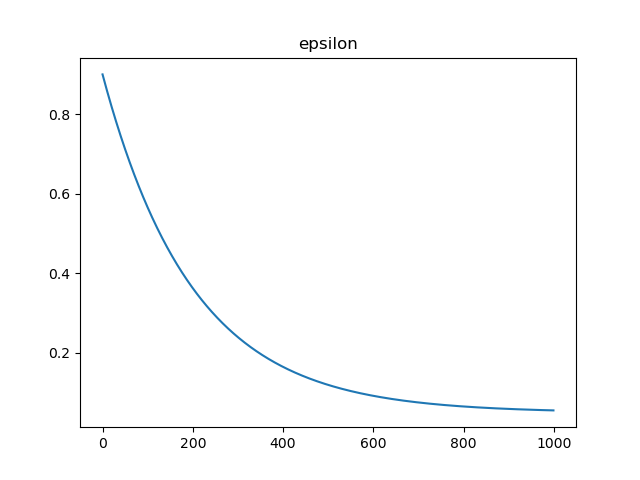

In [48]:
plt.figure()
plt.title("epsilon")
plt.plot([EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY) for steps_done in range(1000)])
plt.show()

In [37]:
criterion = torch.nn.SmoothL1Loss()
# criterion = torch.nn.MSELoss()

In [38]:
loss_history = []
learning_rate_history = []
reward_history = []
duration_history = []
action_history = []
terminal_history = []

In [49]:
# train loop

# optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.RMSprop(policy.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=LEARNING_RATE_UPDATE_INTERVAL,
    gamma=LEARNING_RATE_GAMMA,
)
steps_done = 0
with tqdm(total=TRAIN_EPISODES) as pbar:
    for episode in range(TRAIN_EPISODES):
        state = torch.as_tensor(env.reset(), dtype=torch.float32)

        for i in count():
            epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY)
            steps_done += 1
            #region exploration
            action = get_action(state)
            action_history.append(action)
            next_state, reward, done, info = env.step(action)
            reward_history.append(reward)
            terminal_history.append(done)
            if done:
                duration_history.append(i)
                next_state = torch.zeros(state.shape)
            else:
                next_state = torch.as_tensor(next_state, dtype=torch.float32)                
            memory.append(Transition(
                state=state,
                action=action,
                reward=reward,
                next_state=next_state,
                terminal=done,
            ))
            state = next_state
            #endregion exploration

            if len(memory) >= BATCH_SIZE:
                policy.train()
                batch = sample_memory(BATCH_SIZE)

                # calculate q values for the actions that were taken
                q_pred = policy(batch.states).gather(1, batch.actions.unsqueeze(1))

                # calculate q values for next state
                q_next = torch.zeros(BATCH_SIZE)
                non_final = ~batch.terminals
                q_next[non_final] = policy_target(batch.next_states[non_final]).max(dim=1).values.detach()

                # calculate expected q values
                q_expected = ((q_next * REWARD_GAMMA) + batch.rewards).unsqueeze(1)

                # calculate loss
                policy_loss = criterion(q_pred, q_expected)
                loss_history.append(policy_loss.item())

                # apply weight update
                optimizer.zero_grad()
                policy_loss.backward()
                for param in policy.parameters():
                    param.grad.data.clamp_(-1, 1)
                optimizer.step()
                
                # update learning rate
                learning_rate_history.append(scheduler.get_last_lr())
                scheduler.step()

                ## update target network
                # soft_update(policy_target, policy, SOFT_UPDATE_TAU)
                if i % POLICY_TARGET_UPDATE_INTERVAL == 0:
                    hard_update(policy_target, policy)

                pbar.set_description(f"policy: {policy_loss.item():.3f}, reward: {reward:.3f}, epsilon: {epsilon:.3f}, lr: {scheduler.get_last_lr()[0]:.4f}, steps: {steps_done}")
            else:
                pbar.set_description(f"warmup")
                
            if episode % PREVIEW_EPISODE_INTERVAL == 0:
                env.render()
        
            if done: break

        
        pbar.update()
env.close()

  0%|          | 0/50 [00:00<?, ?it/s]

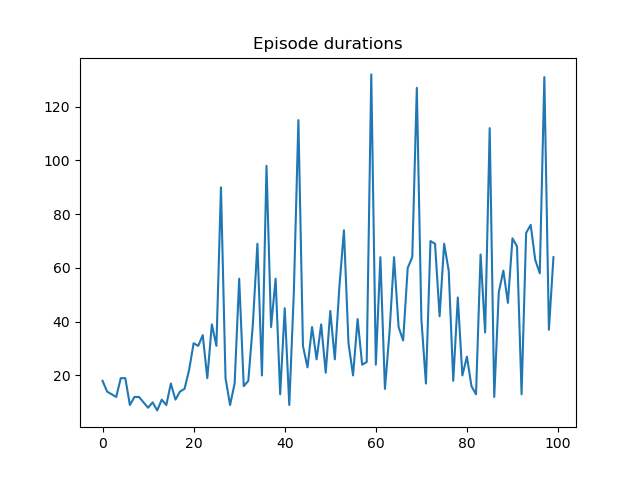

In [50]:
# episode durations
plt.figure()
plt.plot(duration_history)
plt.title("Episode durations")
plt.show()

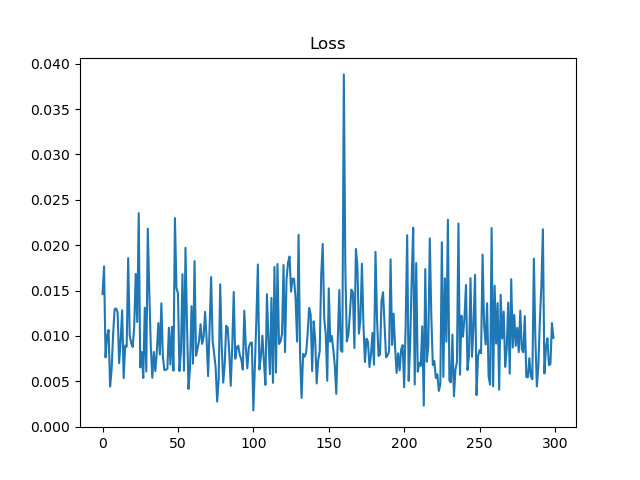

In [51]:
# episode durations
plt.figure()
plt.plot(loss_history[-300:])
plt.title("Loss")
plt.show()

In [52]:
# investigate actions
import ipywidgets as widgets
plt.figure()
@widgets.interact(i=(0, len(action_history)-1), window_size=(1, len(action_history)-1))
def preview_actions(i=len(action_history)-100, window_size=100):
    x = torch.zeros((len(action_history), env.action_space.n + 1))
    x[range(len(action_history)), action_history] = 1
    x[:, 2] = torch.as_tensor(terminal_history, dtype=torch.bool)
    plt.imshow(x[i:i+window_size], aspect="auto")
    plt.show()
    del x

interactive(children=(IntSlider(value=3947, description='i', max=4046), IntSlider(value=100, description='wind…

In [55]:
# preview
epsilon = 0
for _ in range(25):
    state = env.reset()
    done = False
    while not done:
        action = get_action(torch.as_tensor(state))
        next_state, reward, done, info = env.step(action)
        env.render()
        frame = env.render()

env.close()